# Sydney Housing Price Prediction

# Libraries

In [220]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

# Data Import

In [221]:
data = pd.read_csv("../../Data/sydney_housing_2016-2021.csv")
data.head()

,price,date_sold,suburb,num_bath,num_bed,num_parking,property_size,type,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd
0,530000,13/1/16,Kincumber,4,4,2,1351,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05
1,525000,13/1/16,Halekulani,2,4,2,594,House,2538,24752,1.397,-33.21772,151.55237,23,2.0,150.9,78.54
2,480000,13/1/16,Chittaway Bay,2,4,2,468,House,2028,31668,1.116,-33.32678,151.44557,3,2.0,150.9,63.59
3,452000,13/1/16,Leumeah,1,3,1,344,House,9835,32292,4.055,-34.05375,150.83957,81,2.0,150.9,40.12
4,365500,13/1/16,North Avoca,0,0,0,1850,Vacant land,2200,45084,1.497,-33.45608,151.43598,18,2.0,150.9,49.98


## Data Cleaning

### Remove spaces from house type

In [222]:
data.type = data.type.str.replace(' ', '')
data.type.unique()

array(['House', 'Vacantland', 'Townhouse', 'Apartment/Unit/Flat',
       'Semi-Detached', 'NewHouse&Land', 'Duplex', 'Villa', 'Newland',
       'Terrace', 'Studio', 'BlockofUnits', 'DevelopmentSite',
       'Acreage/Semi-Rural', 'NewApartments/OffthePlan', 'Rural'],
      dtype=object)

### Add Suburb Postcode to Data

In [223]:
nsw_postcodes = pd.read_csv('../../Data/nsw_postcodes.csv')
data = data.merge(nsw_postcodes, on='suburb')
data.head()

,price,date_sold,suburb,num_bath,num_bed,num_parking,property_size,type,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd,postcode
0,530000,13/1/16,Kincumber,4,4,2,1351,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05,2251
1,550000,15/1/16,Kincumber,1,3,1,626,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05,2251
2,500000,19/1/16,Kincumber,1,3,1,791,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05,2251
3,540000,22/1/16,Kincumber,1,3,2,623,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05,2251
4,395000,22/1/16,Kincumber,1,1,0,642,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05,2251


### Remove columns not adding value to our model

In [224]:
data.drop(columns=['suburb', 'date_sold'], axis=1, inplace=True)

## Null Values

In [225]:
data.isnull().sum()

price                       0
num_bath                    0
num_bed                     0
num_parking                 0
property_size               0
type                        0
suburb_population           0
suburb_median_income        0
suburb_sqkm                 0
suburb_lat                  0
suburb_lng                  0
suburb_elevation            0
cash_rate                   0
property_inflation_index    0
km_from_cbd                 0
postcode                    0
dtype: int64

# Outlier Detection

In [226]:
data.price.describe().apply(lambda x: format(x, 'f'))

count       11159.000000
mean      1675453.462049
std       1290414.138792
min        225000.000000
25%       1002000.000000
50%       1388000.000000
75%       2020000.000000
max      60000000.000000
Name: price, dtype: object

In [227]:
data.price.median()

1388000.0

## Remove house with price: $60,000,000

In [228]:
data = data[~(data.price == 60000000)]
data.price.describe().apply(lambda x: format(x, 'f'))

count       11158.000000
mean      1670226.311436
std       1166358.460377
min        225000.000000
25%       1002000.000000
50%       1388000.000000
75%       2020000.000000
max      17000000.000000
Name: price, dtype: object

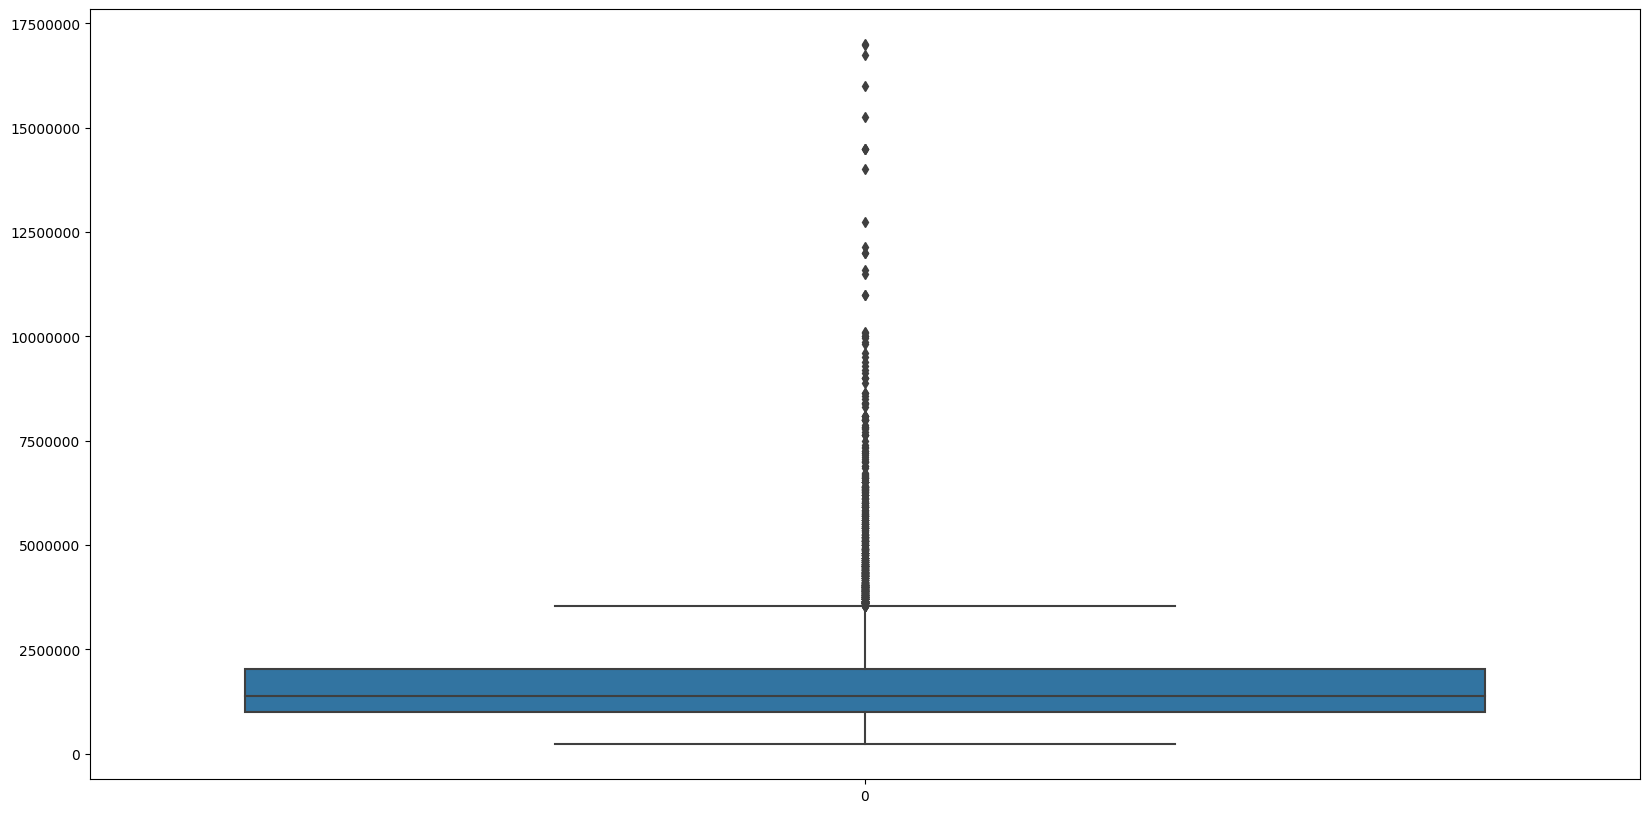

In [229]:
sns.boxplot(data.price)
plt.ticklabel_format(style='plain', axis='y')

In [230]:
q1 = data.price.quantile(0.25)
q3 = data.price.quantile(0.75)
iqr = q3-q1
# not_outliers = data.price[~((data.price<(q1-1.5*iqr)) | (data.price>(q3+1.5*iqr)))]
outliers = data.price[((data.price<(q1-1.5*iqr)) | (data.price>(q3+1.5*iqr)))]
outliers

97       3600000
99       4150000
105      8100000
115      3800000
202      6500000
          ...   
10816    4200000
10848    4800000
10874    4200000
10906    8500000
10946    4260000
Name: price, Length: 581, dtype: int64

## View multivariate outliers using scatter plot

Text(0, 0.5, 'Price')

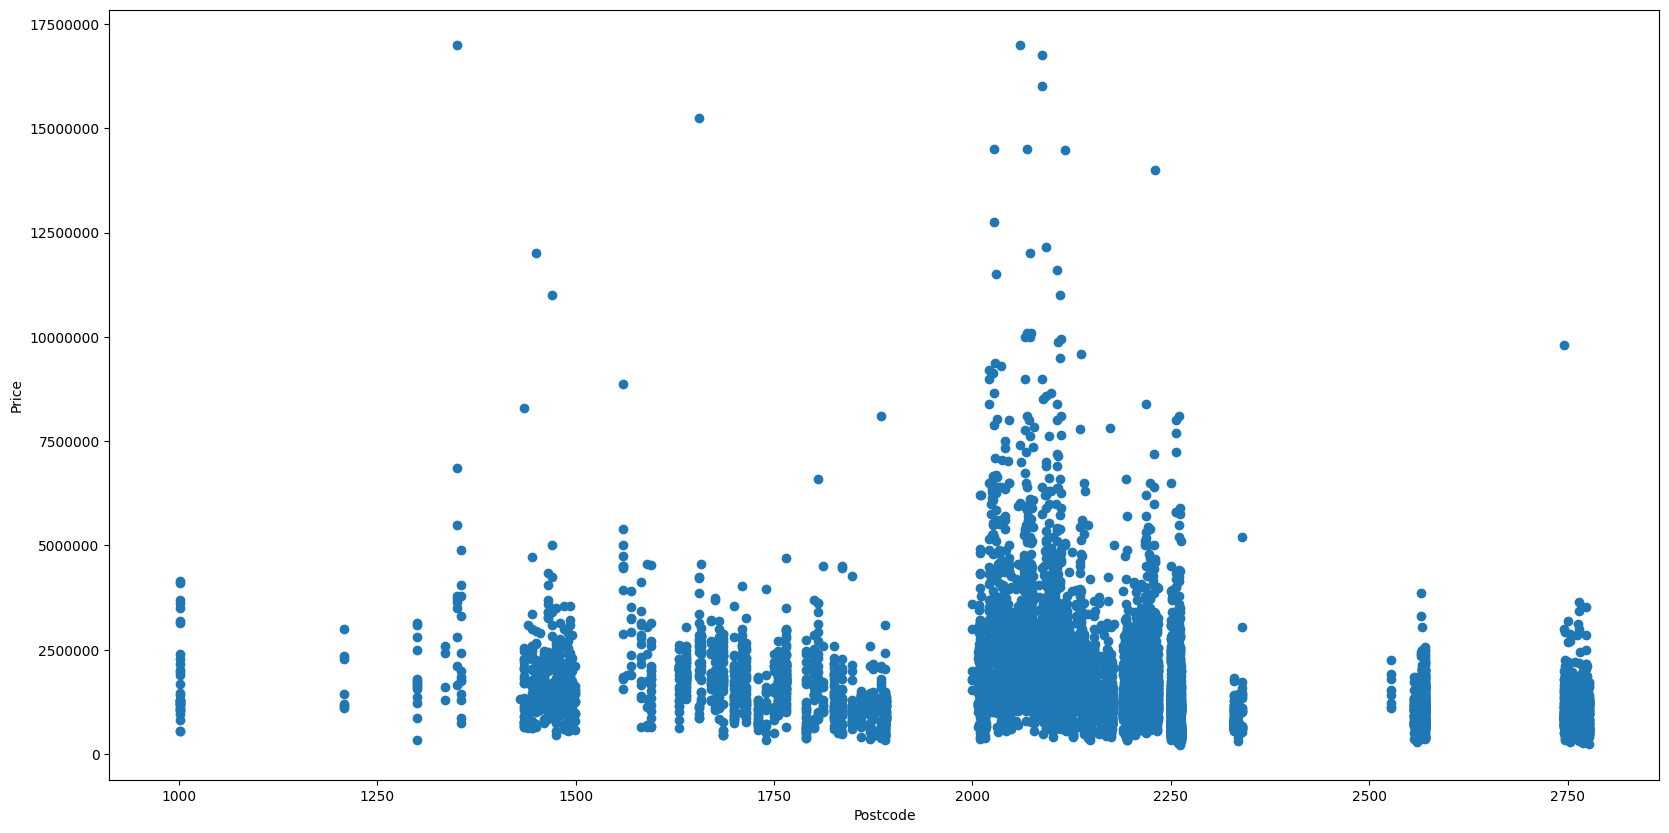

In [231]:
plt.scatter(x=data.postcode, y=data.price)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Postcode')
plt.ylabel('Price')

# Model Creation

## Category Encode Postcode(Dummies)

In [232]:
data_dummies = pd.get_dummies(data, columns=['type', 'postcode'], drop_first=True)
data_dummies.head()

,price,num_bath,num_bed,num_parking,property_size,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,...,postcode_2765,postcode_2766,postcode_2767,postcode_2768,postcode_2769,postcode_2770,postcode_2773,postcode_2774,postcode_2776,postcode_2777
0,530000,4,4,2,1351,7093,29432,9.914,-33.47252,151.40208,...,0,0,0,0,0,0,0,0,0,0
1,550000,1,3,1,626,7093,29432,9.914,-33.47252,151.40208,...,0,0,0,0,0,0,0,0,0,0
2,500000,1,3,1,791,7093,29432,9.914,-33.47252,151.40208,...,0,0,0,0,0,0,0,0,0,0
3,540000,1,3,2,623,7093,29432,9.914,-33.47252,151.40208,...,0,0,0,0,0,0,0,0,0,0
4,395000,1,1,0,642,7093,29432,9.914,-33.47252,151.40208,...,0,0,0,0,0,0,0,0,0,0


In [233]:
X = data_dummies.drop('price', axis=1)
y = data_dummies.price

## Scaling Data

In [239]:
from sklearn.preprocessing import StandardScaler
data_dummies_scaled = data_dummies.copy()
data_dummies_scaled[['price', 'num_bed', 'num_bath', 'num_parking', 'property_size', 'suburb_population', 'suburb_median_income', 'suburb_sqkm', 'suburb_lat', 'suburb_lng', 'suburb_elevation', 'cash_rate', 'property_inflation_index', 'km_from_cbd']] = StandardScaler().fit_transform(data_dummies[['price', 'num_bed', 'num_bath', 'num_parking', 'property_size', 'suburb_population', 'suburb_median_income', 'suburb_sqkm', 'suburb_lat', 'suburb_lng', 'suburb_elevation', 'cash_rate', 'property_inflation_index', 'km_from_cbd']])
X_scaled = data_dummies_scaled.drop('price', axis=1)
y_scaled = data_dummies_scaled.price
X_scaled

,num_bath,num_bed,num_parking,property_size,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,...,postcode_2765,postcode_2766,postcode_2767,postcode_2768,postcode_2769,postcode_2770,postcode_2773,postcode_2774,postcode_2776,postcode_2777
0,1.644074,0.157990,-0.010553,0.599335,-0.294359,-0.968320,0.834121,1.525599,1.430752,-0.598700,...,0,0,0,0,0,0,0,0,0,0
1,-0.914088,-0.490833,-0.703201,-0.092151,-0.294359,-0.968320,0.834121,1.525599,1.430752,-0.598700,...,0,0,0,0,0,0,0,0,0,0
2,-0.914088,-0.490833,-0.703201,0.065222,-0.294359,-0.968320,0.834121,1.525599,1.430752,-0.598700,...,0,0,0,0,0,0,0,0,0,0
3,-0.914088,-0.490833,-0.010553,-0.095012,-0.294359,-0.968320,0.834121,1.525599,1.430752,-0.598700,...,0,0,0,0,0,0,0,0,0,0
4,-0.914088,-1.788478,-1.395849,-0.076890,-0.294359,-0.968320,0.834121,1.525599,1.430752,-0.598700,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11154,0.791353,-0.490833,-0.010553,0.215918,-1.125246,-0.569527,2.639702,-0.078611,-1.156848,0.139900,...,0,1,0,0,0,0,0,0,0,0
11155,-0.061367,0.157990,-0.010553,0.178721,-1.125246,-0.569527,2.639702,-0.078611,-1.156848,0.139900,...,0,1,0,0,0,0,0,0,0,0
11156,-0.061367,0.806812,1.374743,-0.115995,-0.824636,-1.625156,-0.708616,-0.624443,-0.959471,0.064146,...,0,0,0,0,0,0,0,0,0,0
11157,-0.061367,0.157990,-0.010553,-0.079751,-0.819200,-1.723681,-0.713594,-0.668596,-0.965795,-0.579762,...,0,0,0,0,0,0,0,0,0,0


## Train Test Split

In [240]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=0)

## Models

In [241]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression.score(X_test, y_test)

-20730764312884.33

In [242]:
linear_regression2 = LinearRegression()
linear_regression2.fit(X_train_scaled, y_train_scaled)
linear_regression2.score(X_test_scaled, y_test_scaled)

-1.0411185658765257e+21

## Cross Validation

In [243]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X_scaled, y_scaled, cv=cv)

array([-1.04111857e+21,  5.51294979e-01, -5.53626652e+20,  5.35422824e-01,
       -1.82932585e+20])

## Model Selection

In [250]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
        'random_forrest': {
            'model': RandomForestRegressor(),
            'params': {'bootstrap': [True]}
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False, verbose=2)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [252]:
find_best_model_using_gridsearchcv(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............criterion=squared_error, splitter=best; total time=   0.1s
[CV] END .............criterion=squared_error, splitter=best; total time=   0.1s
[CV] END .............criterion=squared_error, splitter=best; total time=   0.1s
[CV] END ...........criterion=squared_error, splitter=random; total time=   0.1s
[CV] END ...........criterion=squared_error, splitter=random; total time=   0.1s
[CV] END ...........criterion=squared_error, splitter=random; total time=   0.1s
[CV] END ..............criterion=friedman_mse, splitter=best; total time=   0.1s
[CV] END ..............criterion=friedman_mse, splitter=best; total time=   0.1s
[CV] END ..............criterion=friedman_mse, splitter=best; total time=   0.1s
[CV] END ............criterion=friedman_mse, splitter=random; total time=   0.1s
[CV] END ............criterion=friedman_mse, splitter=random; total time=   0.1s
[CV] END ............criterion=friedman_mse, spli

,model,best_score,best_params
0,decision_tree,0.374349,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
1,random_forrest,0.689865,{'bootstrap': True}
